In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
%matplotlib inline

- Question 1: (10 points) For visualization purpose, generate heat maps of
Reward function 1 and Reward function 2. For the heat maps, make sure you
display the coloring scale. You will have 2 plots for this question

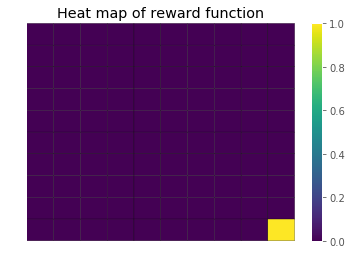

In [48]:
# Q1

def plot_heatmap(R):
    x = np.arange(0,11,1)
    y = np.arange(11,0,-1)
    X, Y = np.meshgrid(x, y)

    plt.pcolor(X,Y,R,edgecolors='k')
    plt.colorbar()
    plt.title('Heat map of reward function')
    plt.axis('off')

R1 = np.zeros((10,10))
R1[9][9] = 1
plot_heatmap(R1)


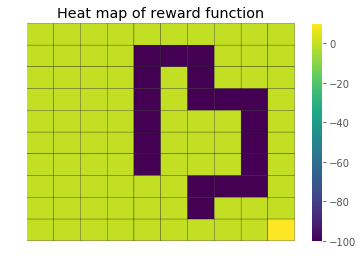

In [49]:
R2 = np.zeros((10,10)) 
R2[1][4:7] = -100
R2[2][4] = R2[2][6] = -100
R2[3][4] = R2[3][6] = R2[3][7] = R2[3][8] = -100
R2[4:7,4] = R2[4:7,8] = -100
R2[7,6:9] = -100
R2[8][6] = -100
R2[9][9] = 10
plot_heatmap(R2)

- Question 2: (40 points) Create the environment of the agent using the information provided in section 2. To be specific, create the MDP by setting up the state-space, action set, transition probabilities, discount factor, and reward function.
After you have created the environment, then write an optimal state-value func-
tion that takes as input the environment of the agent and outputs the optimal
value of each state in the grid. For the optimal state-value function, you have
to implement the Initialization (lines 2-4) and Estimation (lines 5-13) steps of
the Value Iteration algorithm. For the estimation step, use epsilon = 0.01. For visualization purpose, you should generate a figure similar to that of figure 1 but
with the number of state replaced by the optimal value of that state. In this
question, you should have 1 plot.

In [10]:
# Q2
import copy
# up: 0, right: 1, down: 2, left: 3
def is_intended(act,s,t): # return whether next state is the intended state
    if (act == 0 and s - 1 == t) or (act == 1 and s + 10 == t) or \
    (act == 2 and s + 1 == t) or (act == 3 and s - 10 == t):
        return True
    else:
        return False

def is_interior(s):
    x = s % 10
    y = s // 10
    if y == 0 or y == 9 or x == 0 or x == 9:
        return False
    else:
        return True

def is_edge(s):
    x = s % 10
    y = s // 10
    if x == 0 and y in range(1, 9): # up edge 
        return 0
    elif y == 9 and x in range(1, 9): # right edge 
        return 1
    elif x == 9 and y in range(1, 9): # down edge
        return 2
    elif y == 0 and x in range(1, 9): # left edge
        return 3
    else:
        return -1 # not an edge
    
def is_corner(s):
    if s in [0,9,90,99]:
        return True
    else:
        return False
def get_prob_matrix(w): 
    # up: 0, right: 1, down: 2, left: 3
    Prob = np.zeros((4,100,100)) # s-state, t-state

    
    #corner_state = [(0,0),(9,9),(90,90),(99,99)] # stay in corner
    corner_state = [0,9,90,99]
    for act in range(0, 4):
        for s in range(0, 100):
            
            if is_interior(s):     # s is inner state (has 4 directions)
                for t in [s - 1, s + 1, s - 10, s + 10]: # all in range
                    if is_intended(act,s,t): # correct state
                        Prob[act,s,t] = 1 - w + w / 4
                    else:
                        Prob[act,s,t] = w / 4
            elif is_edge(s) != -1:
                if is_edge(s) == act: # off grid direction,stay
                    Prob[act,s,s] = 1 - w + w / 4
                else:
                    Prob[act,s,s] = w / 4
                if is_edge(s) == 0:
                     for t in [s + 1, s - 10, s + 10]:
                        if is_intended(act,s,t): # correct state
                            Prob[act,s,t] = 1 - w + w / 4
                        else:
                            Prob[act,s,t] = w / 4
                elif is_edge(s) == 2:  
                     for t in [s - 1, s - 10, s + 10]:
                        if is_intended(act,s,t): # correct state
                            Prob[act,s,t] = 1 - w + w / 4
                        else:
                            Prob[act,s,t] = w / 4
                else:
                    for t in [s - 1, s + 1, s - 10, s + 10]:
                        if t >= 0 and t <= 99:
                            if is_intended(act,s,t): # correct state
                                Prob[act,s,t] = 1 - w + w / 4
                            else:
                                Prob[act,s,t] = w / 4

                        
    #corner states:
    # left-up corner
    Prob[0, 0, 0] = 1 - w + w / 4 + w / 4
    Prob[0, 0, 10] = w / 4
    Prob[0, 0, 1] = w / 4
    
    Prob[1, 0, 0] = w / 4 + w / 4
    Prob[1, 0, 10] = 1 - w + w / 4
    Prob[1, 0, 1] = w / 4
    
    Prob[2, 0, 0] = w / 4 + w / 4
    Prob[2, 0, 10] = w / 4
    Prob[2, 0, 1] = 1 - w + w / 4
    
    Prob[3, 0, 0] = 1 - w + w / 4 + w / 4
    Prob[3, 0, 10] = w / 4
    Prob[3, 0, 1] = w / 4 
    
    # left-down corner
    Prob[0, 9, 9] = w / 4 + w / 4
    Prob[0, 9, 8] = 1 - w + w / 4
    Prob[0, 9, 19] = w / 4
    
    Prob[1, 9, 9] = w / 4 + w / 4
    Prob[1, 9, 8] = w / 4
    Prob[1, 9, 19] = 1 - w + w / 4
    
    Prob[2, 9, 9] = 1 - w + w / 4 + w / 4
    Prob[2, 9, 8] = w / 4
    Prob[2, 9, 19] = w / 4
    
    Prob[3, 9, 9] = 1 - w + w / 4 + w / 4
    Prob[3, 9, 8] = w / 4
    Prob[3, 9, 19] = w / 4 
    
    # right-up corner
    
    Prob[0, 90, 90] = 1 - w + w / 4 + w / 4
    Prob[0, 90, 91] = w / 4
    Prob[0, 90, 80] = w / 4
    
    Prob[1, 90, 90] = 1 - w + w / 4 + w / 4
    Prob[1, 90, 91] = w / 4
    Prob[1, 90, 80] = w / 4
    
    Prob[2, 90, 90] = w / 4 + w / 4
    Prob[2, 90, 91] = 1 - w + w / 4
    Prob[2, 90, 80] = w / 4
    
    Prob[3, 90, 90] = w / 4 + w / 4
    Prob[3, 90, 91] = w / 4
    Prob[3, 90, 80] = 1 - w + w / 4
    
    # right-down corner
    Prob[0, 99, 99] = w / 4 + w / 4
    Prob[0, 99, 98] = 1 - w + w / 4
    Prob[0, 99, 89] = w / 4
    
    Prob[1, 99, 99] = 1 - w + w / 4 + w / 4
    Prob[1, 99, 98] = w / 4
    Prob[1, 99, 89] = w / 4
    
    Prob[2, 99, 99] = 1 - w + w / 4 + w / 4
    Prob[2, 99, 98] = w / 4
    Prob[2, 99, 89] = w / 4
    
    Prob[3, 99, 99] = w / 4 + w / 4
    Prob[3, 99, 98] = w / 4
    Prob[3, 99, 89] = 1 - w + w / 4 

    return Prob


In [30]:
def get_opt_state_val(R,eps,w,gamma,Prob): # R: reward function, eps, w, gamma: discount factor
    V = np.zeros((100,1))
    
    delta = float('inf') # infinity
    #count = 0
    corner = [0,9,90,99]
    while delta > eps:
        delta = 0
        #print("iter:",count)
        for s in range(0,100):
            #v = V[s]
            v = copy.deepcopy(V[s])
            act_val = [] # length = 4
            for act in range(0, 4): 
                val = 0    
                for t in range(0, 100):
                    val += Prob[act, s, t] * (R[t % 10, t // 10] + gamma * V[t])
                act_val.append(val)
            V[s] = max(act_val)
            delta = max(delta, abs(v - V[s])) # update delta
            #PI[s] = act_val.index(V[s])
        #count += 1
    return V
            

In [42]:
def get_opt_policy(V,R,Prob,gamma):
    PI = np.zeros((100,1))
    for s in range(0,100):
        act_val = [] # length = 4
        for act in range(0, 4): 
            val = 0    
            for t in range(0, 100):
                val += Prob[act, s, t] * (R[t % 10, t // 10] + gamma * V[t])
            act_val.append(val)
        opt_val = max(act_val)
        PI[s] = act_val.index(opt_val) 
    return PI

In [12]:
def plot_val_map(V):
    V = V.reshape((10,10))
    V = V.T
    print(V)
    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=True, xlim=(0, 10), ylim=(10, 0))
    for i in range(0,10):
        for j in range(0,10):
            state = V[i, j]
            ax.annotate(round(state,1),
                    xy=(j+0.1, i), xycoords='data',
                    xytext=(0, -15), textcoords='offset points',)

In [43]:
p = get_prob_matrix(0.1)
V1 = get_opt_state_val(R1,0.01,0.1,0.8,p)  #R,eps,w,gamma,Prob
PI1 = get_opt_policy(V1,R1,p,0.8)

[[ 0.04179568  0.06283791  0.089742    0.12384898  0.16708096  0.22188288
   0.29135376  0.37942014  0.49098293  0.60964773]
 [ 0.06283791  0.08787011  0.12155728  0.16451357  0.21924607  0.28898976
   0.37787112  0.49106061  0.63321853  0.78735399]
 [ 0.089742    0.12155728  0.16438987  0.21913198  0.28890328  0.37782648
   0.49115592  0.63549019  0.81735527  1.01859718]
 [ 0.12384898  0.16451357  0.21913198  0.28889981  0.37782476  0.49115916
   0.6356006   0.81960951  1.05219113  1.31505855]
 [ 0.16708096  0.21924607  0.28890328  0.37782476  0.49115918  0.63560325
   0.81969511  1.05426506  1.35157155  1.69507283]
 [ 0.22188288  0.28898976  0.37782648  0.49115916  0.63560325  0.8196963
   1.05432164  1.35332408  1.73318006  2.18223115]
 [ 0.29135376  0.37787112  0.49115592  0.6356006   0.81969511  1.05432164
   1.35335083  1.73446085  2.21952677  2.80680236]
 [ 0.37942014  0.49106061  0.63549019  0.81960951  1.05426506  1.35332408
   1.73446085  2.22020148  2.839257    3.60762627]
 

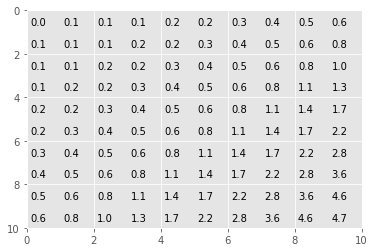

In [44]:
plot_val_map(V1)

- Question 3: (5 points) Generate a heat map of the optimal state values across
the 2-D grid. For generating the heat map, you can use the same function provided in the hint earlier (see the hint after question 1).

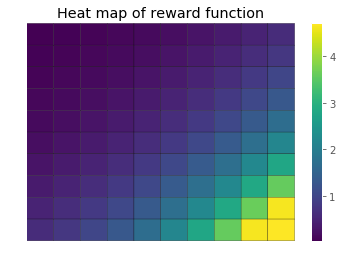

In [45]:
V1 = V1.reshape((10,10))
V1 = V1.T
plot_heatmap(V1)

- Question 4: (15 points) Explain the distribution of the optimal state values
across the 2-D grid. (Hint: Use the figure generated in question 3 to explain)

In [16]:
print("The distribution of the optimal values are symmetric with respect to the diagonal.")

The distribution of the optimal values are symmetric with respect to the diagonal.


- Question 5: (30 points) Implement the computation step of the value iteration
algorithm (lines 14-17) to compute the optimal policy of the agent navigating
the 2-D state-space. For visualization purpose, you should generate a figure
similar to that of figure 1 but with the number of state replaced by the optimal
action at that state. The optimal actions should be displayed using arrows.
Does the optimal policy of the agent match your intuition? Please provide a
brief explanation. Is it possible for the agent to compute the optimal action to
take at each state by observing the optimal values of it's neighboring states? In
this question, you should have 1 plot.

In [17]:
def plot_opt_policy(PI):
    PI = PI.reshape((10,10))
    PI = PI.T
    print(PI)
    fig = plt.figure()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, 10), ylim=(10, 0))
    for i in range(0,10):
        for j in range(0,10):
            act = PI[i, j]
            if act==0:
                ax.annotate('',
                    xy=(j+0.5, i), xycoords='data',
                    xytext=(0, -15), textcoords='offset points',
                    arrowprops=dict(facecolor='black', shrink=0.0000001,headlength=5),
                    horizontalalignment='bottom', verticalalignment='up')
            elif act==1:
                ax.annotate('',
                    xy=(j+0.7, i+0.3), xycoords='data',
                    xytext=(-15, 0), textcoords='offset points',
                    arrowprops=dict(facecolor='black', shrink=0.0000001,headlength=5),
                    horizontalalignment='right', verticalalignment='left')
            elif act==2:
                ax.annotate('',
                    xy=(j+0.5, i+0.7), xycoords='data',
                    xytext=(0, 15), textcoords='offset points',
                    arrowprops=dict(facecolor='black', shrink=0.0000001,headlength=5),
                    horizontalalignment='up', verticalalignment='bottom')
            elif act==3:
                ax.annotate('',
                    xy=(j+0.25, i+0.3), xycoords='data',
                    xytext=(15, 0), textcoords='offset points',
                    arrowprops=dict(facecolor='black', shrink=0.0000001,headlength=5),
                    horizontalalignment='left', verticalalignment='right')




[[ 1.  1.  1.  1.  1.  1.  1.  2.  2.  2.]
 [ 2.  1.  1.  1.  1.  1.  2.  2.  2.  2.]
 [ 2.  2.  1.  1.  1.  2.  2.  2.  2.  2.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 2.  2.  2.  1.  2.  2.  2.  2.  2.  2.]
 [ 2.  2.  1.  1.  1.  2.  2.  2.  2.  2.]
 [ 2.  1.  1.  1.  1.  1.  2.  2.  2.  2.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  2.  2.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]


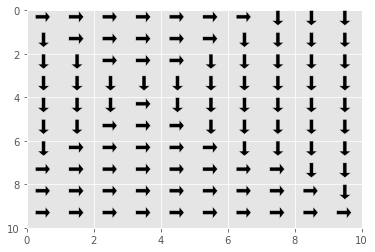

In [46]:
plot_opt_policy(PI1)

- Question 6: (10 points) Modify the environment of the agent by replacing Reward function 1 with Reward function 2. Use the optimal state-value function
implemented in question 2 to compute the optimal value of each state in the
grid. For visualization purpose, you should generate a figure similar to that
of figure 1 but with the number of state replaced by the optimal value of that
state. In this question, you should have 1 plot.

[[  6.48477467e-01   7.94106515e-01   8.25237900e-01   5.36245558e-01
   -2.37043156e+00  -4.23381678e+00  -1.92052971e+00   1.13110795e+00
    1.59435584e+00   2.03820726e+00]
 [  8.29851948e-01   1.02123596e+00   1.06603296e+00  -1.86790436e+00
   -6.73821942e+00  -8.67375446e+00  -6.36979468e+00  -1.29479626e+00
    1.92834321e+00   2.61046947e+00]
 [  1.06360962e+00   1.31651254e+00   1.45007729e+00  -1.62402502e+00
   -6.74150886e+00  -1.39111818e+01  -9.64922518e+00  -5.51104325e+00
   -1.31012708e-01   3.35905866e+00]
 [  1.36025245e+00   1.69269877e+00   1.94802285e+00  -1.23216899e+00
   -6.32308479e+00  -7.97760603e+00  -7.93667980e+00  -9.42386879e+00
   -1.91442835e+00   4.39062525e+00]
 [  1.73657224e+00   2.17160228e+00   2.58983267e+00  -7.25587435e-01
   -5.83072992e+00  -3.25362550e+00  -3.23020014e+00  -7.41906241e+00
    1.71898209e+00   9.16310147e+00]
 [  2.21393346e+00   2.78108417e+00   3.41709976e+00  -2.75630965e-02
   -5.09866208e+00  -5.49015498e-01  -4.76652

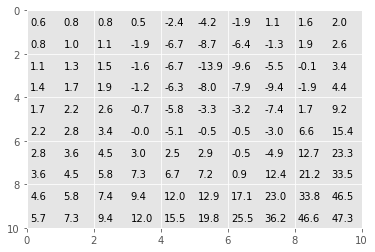

In [51]:
V2 = get_opt_state_val(R2,0.01,0.1,0.8,p)
plot_val_map(V2)
PI2 = get_opt_policy(V2,R2,p,0.8)

- Question 7: (10 points) Generate a heat map of the optimal state values (found
in question 6) across the 2-D grid. For generating the heat map, you can use
the same function provided in the hint earlier.

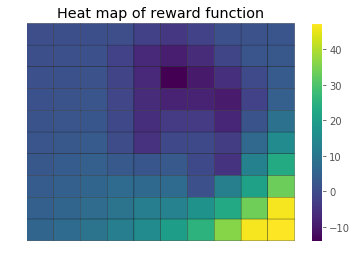

In [52]:
V2 = V2.reshape((10,10))
V2 = V2.T
plot_heatmap(V2)

- Question 8: (20 points) Explain the distribution of the optimal state values across the 2-D grid. (Hint: Use the figure generated in question 7 to explain)

- Question 9: (20 points) Implement the computation step of the value iteration
algorithm (lines 14-17) to compute the optimal policy of the agent navigating
the 2-D state-space. For visualization purpose, you should generate a figure
similar to that of figure 1 but with the number of state replaced by the optimal
action at that state. The optimal actions should be displayed using arrows.
Does the optimal policy of the agent match your intuition? Please provide a
brief explanation. In this question, you should have 1 plot.

[[ 2.  2.  2.  3.  3.  1.  1.  1.  1.  2.]
 [ 2.  2.  2.  3.  3.  0.  1.  1.  1.  2.]
 [ 2.  2.  2.  3.  3.  2.  1.  1.  1.  2.]
 [ 2.  2.  2.  3.  3.  2.  2.  0.  1.  2.]
 [ 2.  2.  2.  3.  3.  2.  2.  2.  1.  2.]
 [ 2.  2.  2.  3.  3.  2.  2.  3.  1.  2.]
 [ 2.  2.  2.  2.  2.  2.  3.  3.  1.  2.]
 [ 2.  2.  2.  2.  2.  2.  3.  2.  2.  2.]
 [ 1.  1.  1.  2.  2.  2.  2.  2.  2.  2.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]


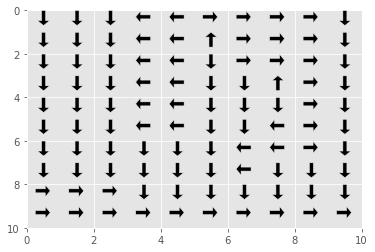

In [53]:
plot_opt_policy(PI2)

In [54]:
# extracted reward test

extractreward = [[-1.34408545e-11, -1.23366506e-11, -1.16454605e-12, -1.95971486e-12,
  -1.34891586e-11, -3.81291446e-12, -2.11006884e-12, -7.64973784e-13,
   5.74729191e-13,  1.67306571e-12],
 [-2.48675135e-12, -1.01460977e-12,  4.17127121e-13, -2.43626258e-12,
  -1.37390517e-11, -1.41165675e-11, -1.29615569e-11, -9.49994513e-13,
   8.09421583e-13,  4.68452301e-12],
 [-6.21560993e-13,  1.64531806e-13,  8.22943182e-13, -1.76107393e-12,
  -1.35363460e-11, -1.46096331e-11, -1.31834078e-11,  5.05248678e-13,
   2.04129503e-13,  5.18956569e-12],
 [ 2.03593417e-13,  6.09572780e-13,  1.42724741e-12, -1.09440246e-12,
  -1.31661529e-11, -3.27443034e-12, -1.31445756e-11, -1.13808728e-11,
  -9.92420864e-12,  5.50674965e-12],
 [ 6.43847826e-13,  1.19383606e-12,  1.51018212e-12, -7.78330482e-13,
  -1.16328192e-11, -2.32373130e-12, -1.50073402e-12, -1.18053750e-11,
  -9.31181121e-12,  5.62747588e-12],
 [ 1.14657838e-12,  1.32513548e-12,  2.21793011e-12, -2.41033320e-13,
  -1.07840896e-11, -4.95311450e-13,  9.34899307e-13,  4.25448048e-14,
  -1.02496180e-11,  5.71278892e-12],
 [ 1.46627696e-12,  2.11128786e-12, 1.72026199e-12, -9.06125555e-12,
  -9.26277918e-12,  2.01928058e-12,  4.50910667e-12, -1.15594067e-11,
  -8.30635054e-12,  5.85941099e-12],
 [ 2.25460795e-12,  2.29712166e-12,  3.03817078e-12,  2.25060989e-12,
   2.01589810e-12,  6.31960178e-12, -9.53313192e-12, -7.25470519e-12,
  -8.78770004e-12,  5.74419688e-12],
 [ 2.55228558e-12,  6.07218448e-12,  1.06375787e-11,  1.24067290e-11,
   6.46261607e-12,  3.50299794e-12, -4.88360287e-12, -5.30758668e-13,
   5.88376245e-12,  7.00266966e-12],
 [-8.75365289e-12,  2.57643411e-12,  6.17533528e-12,  1.51108496e-11,
   1.78273573e-11,  1.98885760e-11,  2.24784591e-11,  2.65499144e-11,
   3.43913250e-11,  9.37436835e-11]]


In [56]:
extractreward = np.array(extractreward)

[[ -3.28070399e-12  -1.67767940e-12  -3.42337887e-14  -1.54966650e-12
   -3.73551758e-12  -2.81199004e-12  -1.23595406e-12   4.11279492e-13
    1.57129080e-12   4.46263112e-12]
 [ -1.06411339e-12  -3.54650224e-14   6.44443007e-13   3.95241070e-13
   -3.06432665e-12  -6.70186108e-12  -1.77275233e-12   3.90953457e-13
    4.36815027e-12   5.20438357e-12]
 [  9.34471295e-14   7.36717136e-13   1.31834168e-12   1.31802483e-12
   -1.75281248e-12  -4.21884957e-12  -6.70371151e-13  -4.54625441e-13
    4.66338030e-12   8.55020635e-12]
 [  6.02218312e-13   1.38603160e-12   1.79014973e-12   2.27863622e-12
   -7.22776116e-14  -3.25828304e-12  -2.16271983e-12  -7.84176177e-13
    4.65911365e-12   1.12509337e-11]
 [  1.16619321e-12   1.69982120e-12   2.74474697e-12   3.14939757e-12
    9.52303609e-13  -9.14482269e-13   1.21395770e-13  -5.28737114e-13
    4.48854268e-12   1.35599165e-11]
 [  1.55699199e-12   2.53020079e-12   3.54874434e-12   4.22505222e-12
    2.38785615e-12   1.59297897e-12   4.15637

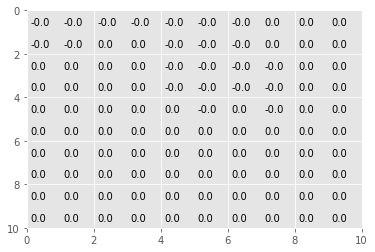

In [57]:
ext_V = get_opt_state_val(extractreward,0.01,0.1,0.8,p)
plot_val_map(ext_V)

[[ 2.  2.  2.  3.  3.  1.  1.  1.  1.  2.]
 [ 2.  1.  2.  3.  3.  0.  1.  1.  1.  2.]
 [ 1.  1.  2.  3.  3.  2.  1.  1.  1.  2.]
 [ 1.  1.  2.  3.  3.  2.  2.  0.  1.  2.]
 [ 1.  1.  2.  3.  3.  2.  2.  2.  1.  2.]
 [ 2.  1.  2.  3.  3.  2.  2.  3.  1.  2.]
 [ 2.  2.  2.  2.  2.  2.  3.  3.  1.  2.]
 [ 1.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 1.  1.  1.  2.  2.  2.  2.  2.  2.  2.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]


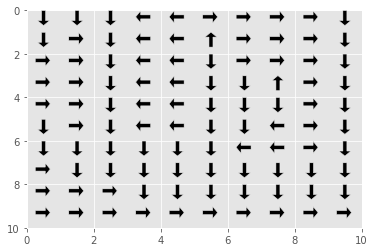

In [59]:
ext_PI = get_opt_policy(ext_V,extractreward,p,0.8)
plot_opt_policy(ext_PI)
#PI2 = get_opt_policy(V2,R2,p,0.8)